# Übung 1 - Modellierung von PV-Stromerzeugung

Gruppe: 4

Autor: Konstantinos Zafeiris

# Introduction

In times of an energy crisis and global shortages the existence of a photovoltaic system as a renewable energy source can serve to alleviate pressure from both the financial burden and the dependance to the grid for small households as well as whole companies alike. On the other hand energy supply companies can invest on an energy source that is both environment friendly and realtively easy to harvest. 

The scope of this exercise if to explroe the energy that is produced by a photovoltaic system by creating a model to extract from raw data meaningful and useful information. Since the photovoltaic energy generation is fluctuating according to weather, location, time of day and season, the influence of the time factor is taken into consideration.

## Abbreviations and Variables

In the following many variables and abbreviations are used in great abundance so the following serve as a reference.

- PV - PhotoVoltaic
- $\delta$ - Solar Declination
- $\sigma$ - Hour Angle
- $\alpha_\sigma$ - Solar Azimuth
- $\gamma_\sigma$ - Solar Altitude/Elevation
- $\alpha_{PV}$ - PhotoVoltaic Azimuth
- $\gamma_{PV}$ - PhotoVoltaic Inclination

In [9]:
# Import libraries 
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta

In [10]:
# Define Exercise and group specific constants
INSTALLIERTE_LEISTUNG = 1  # kWp
EFFICIENCY_FACTOR = 0.17
LOSSES_FACTOR = 0.8
PV_HEIGHT_ANGLE_DEGREES = 20  # Degrees, Neigungswinkel
PV_HEIGHT_ANGLE_RADIANS = np.radians(PV_HEIGHT_ANGLE_DEGREES)
PV_AZIMUTH_DEGREES = 180  # South
PV_AZIMUTH_RADIANS = np.radians(PV_AZIMUTH_DEGREES)
KWP_COSTS = 2000
VIENNA_LONGITUDE = 16.3
VIENNA_LATITUDE = 48.2
ALBEDO_FACTOR = 0.2

__The following function is given to calculate the sun's altitude, given a specific latitude and longitude:__

In [11]:
def sonnenstand(laengengrad,breitengrad,time):
    """
    Diese Funktion erstellt einen Vektor für den Sonnenstand in 15 min
    Auflösung über ein Jahr

    die Variable "azimut" ergibt einen Vektor des azimuts über ein Jahr
    der azimut ergibt nur für positive Hoehenwinkel verlässliche Werte, da
    die atan-Funktion nur Abweichungen bis zu 90° liefert. In weiteren 
    Berechnungen sollten also nur jene Werte mit positiven Hoehenwinkeln 
    (nach Sonnenaufgang) verwendet werden. Für die Berechnung von PV-Erträgen
    reicht dies vollkommen aus. 
    die Variable "hoehenwinkel" ergibt einen Vektor aller hoehenwinkel über 
    ein Jahr
    für Schaltjahre muss die Berechnung dementsprechend angepasst werden. Dies
    Anpassung muss im Rahmen dieser LV allerdings nicht berücksichtigt werden.

    Quellen zur Berechnung des Sonnenstands: Ursula Eicker(2012), 
    Jakob Anger(2012), Rainer Blabensteiner(2011)

    Args:
        laengengrad: float
        breitengrad: float
        time: pandas.Dataframe

    Returns:
        azimut: numpy.array
        hoehenwinkel: numpy.array
    
    """
    ## Zeitgleichung zur Berechnung der wahren Ortszeit
    
    # Zeitgleichung - ergibt die 
    # Abweichung der Sonnenuhr von der mittlerer Ortszeit(MOZ)
    hw1 = 360 / 365 * time['Tag'] # Hilfswinkel 1
    
    z = 0.008 * np.cos(np.radians(hw1)) - 0.122 * np.sin(np.radians(hw1)) \
        - 0.052 * np.cos(np.radians(2 * hw1)) - 0.157 * np.sin(np.radians(2 * hw1)) \
        - 0.001 * np.cos(np.radians(3 * hw1)) - 0.005 * np.sin(np.radians(3 * hw1))

    WOZ = time['Stunden'] + z + 1 / 15 * laengengrad - math.floor(1/15 * laengengrad) # Wahre Ortszeit (WOZ), der Vektor 
    # time.Stunden entspricht der mittleren Ortszeit (MOZ) in Stunden
    
    ## Stundenwinkel bei Berechnung über True Solar Time
    # time.Stunden entspricht hier der Sonnenzeit und nicht der Ortszeit
    # Stw=15*time.Stunden; #Stundenwinkel 
    Stw = 15 * WOZ # Stundenwinkel
    
    ## Berechnung der Deklination
    
    Ew = 0.98630 * (np.array(time.Tag) - 2.8749) + 1.9137 * np.sin(np.radians(0.98630 * (np.array(time.Tag) - 2.8749))) + 102.06 # Ekliptikale Länge in Grad    
    Dw = np.degrees(np.arcsin(-0.3979 * np.sin(np.radians(Ew)))) # Winkel zwischen Äquatorebene und Verbindungs-
    # linie Sonne-Erde. Dieser Winkel wird als Sonnendeklination bezeichnet
    # und schwankt über das Jahr zwischen 23°26,5' und -23°26,5'

    ## Berechnung des Höhenwinkels

    hoehenwinkel = np.degrees(np.arcsin(np.sin(np.radians(Dw)) * np.sin(np.radians(breitengrad)) - np.cos(np.radians(Dw)) * np.cos(np.radians(breitengrad)) * np.cos(np.radians(Stw))))

    ## Berechnung des Azimuts
    # Winkel nach Sonnenuntergang werden hier nicht vollständig abgebildet

    azimutfull = 180 + np.degrees(np.arctan(-np.cos(np.radians(Dw)) * np.sin(np.radians(Stw)) / (-np.cos(np.radians(Dw)) * np.sin(np.radians(breitengrad)) * np.cos(np.radians(Stw)) - np.sin(np.radians(Dw)) * np.cos(np.radians(breitengrad)))))
    
    
    azimutfull[hoehenwinkel < -20] = 0 # Eliminiert
    # unter -20°

    azimutaufteilung = np.reshape(np.array(azimutfull), (96, 365), order="F") # teilt Vektor auf Tage auf
    az1 = azimutaufteilung[0:int((len(time['Stunden'])//365)//2), :] # ergibt Werte für die erste Tageshälfte
    az1[az1 > 220] = az1[az1 > 220] - 180 # Korrektur der Winkel für Abweichungen von über 90° aus Südrichtung
    az11 = az1[0:int(len(time['Stunden'])//365*0.25), :]
    az11[az11 >= 180] = az11[az11 >= 180] - 180
    az1[0:len(az11[:, 0]), :] = az11

    az2 = azimutaufteilung[int((len(time['Stunden'])//365)//2):, :] # ergibt Werte für die zweite Tageshälfte
    az2[(az2 < 150) & (az2 > 0)] = az2[(az2 < 150) & (az2 > 0)] + 180 # Korrektur der Winkel für Abweichungen von über 90° aus Südrichtung
    az22 = az2[int(len(az2[:, 0])*0.5):, :]
    az22[(az22 <= 180) & (az22 > 0)] = az22[(az22 <= 180) & (az22 > 0)] + 180
    az2[int(len(az2[:, 0])-len(az22[:, 0])):, :] = az22
    
    print(len(az1) + len(az2))
    azimutaufteilung = np.concatenate((az1, az2), axis=0) # Zusammenfassung der ersten und zweiten Tageshälfte
    azimut = np.reshape(azimutaufteilung, (35040, ), order="F") # reshape der Tage in einen Vektor aller Winkel über den Jahresverlauf in 15min Intervalle

    return azimut, hoehenwinkel


## 1. Modellimplementierung

In [12]:
# Load the radiation data
dfStrahlung: DataFrame = pd.read_csv("Strahlung.csv")

In [13]:
# Load the time data
time_df: DataFrame = pd.read_csv("time.csv")

In [14]:
# Load the temperature data
temps_df: DataFrame = pd.read_csv("Temperatur.csv")

__Calculation of PV yield__  
To calculate the yield of the Photovoltaik installation we need to calculate the azimuth and the elevation angle for every given timestamp that is provided. In the given data the given timeframe spans one year and is separated in 15-minute increments. Therefore we can calculate the Sun's altitude with the given `sonnenstand()` function given that we provide the correct longitude and latitude for the location of interest. The resulting vector has 35040 entries. When unpacked this provides one vector for the solar azimuths and one for the solar altitude.

In [15]:
# Calculate two vectors of sun's azimuth and height angle using the sonnenstand() function
alpha_s, gamma_s = sonnenstand(VIENNA_LONGITUDE, VIENNA_LATITUDE, time_df)

96


__Angle between sun and PV installation__  
To calculate the annual yield first we have to calculate the angle between the sun and the PV installation.  
This can be calculated with the following equation:
$$ \theta_{gen} = arccos[−cos(\gamma_{\sigma}) · sin(\gamma_{PV}) · cos(\alpha_{\sigma} − \alpha_{PV} − 270^{\circ}
) + sin(\gamma_{\sigma}) · cos(\gamma_{PV})] $$

In [16]:
def incidence_angle(gamma_s, alpha_s, alpha_pv_rad, gamma_pv_rad) -> np.ndarray:
    """
    Calculate the incidence angle between the solar radiation and the PV panel based on the solar altitude and azimuth angles.

    Args:
    solar_altitudes (np.ndarray): A numpy array of shape (n, 1) containing solar altitude angles in degrees.
    solar_azimuths (np.ndarray): A numpy array of shape (n, 1) containing solar azimuth angles in degrees.

    Returns:
    np.ndarray: A numpy array of shape (n, 1) containing incidence angles between solar radiation and a PV panel in degrees.

    Raises:
    ValueError: If the input arrays are not numpy arrays of shape (n, 1).
    """
    theta_gen = np.empty(shape=(35040, 1))
    for index, (altitude, azimuth) in enumerate(zip(gamma_s, alpha_s)):
        azimuth = np.radians(azimuth)
        altitude = np.radians(altitude)
        cos_sun_height = -np.cos(altitude)
        sin_pv_height = np.sin(gamma_pv_rad)
        big_cos = np.cos(azimuth - alpha_pv_rad - np.radians(180))
        sin_altitude = np.sin(altitude)
        cos_pv_height = np.cos(gamma_pv_rad)
        new_theta = (cos_sun_height * sin_pv_height * big_cos) + (sin_altitude * cos_pv_height)
        new_theta = np.arccos(new_theta)
        new_theta = np.degrees(new_theta)
        theta_gen[index, 0] = new_theta
    # θgen = arccos[−cos(γS) · sin(γPV) · cos(αS − αPV − 180◦) + sin(γS) · cos(γPV)]
    return theta_gen

__Calculation of partial Radiation__  
To calculate the partial radiations, namely the *direct*, *reflective* and *diffuse* radiations we will use the formulae according to Blabensteiner [1].  
Those are defined as:  
$$ G_{dir,gen} = G_{dir,hor}\cdot\biggl\{max\biggl(0,\frac{cos(\theta_{gen})}{sin(\gamma_{\sigma})}\biggr)\biggr\}$$  


$$ G_{refl,gen} = G_{G,hor}\cdot A \cdot \frac{1 - cos(\gamma_{PV})}{2}$$  

$$ G_{diff,gen} = G_{diff,hor} \cdot \frac{1 + cos(\gamma_{PV})}{2}$$  

which are respectively:  
>$G_{dir,gen}:$ The incident radiation on an inclined surface due to direct radiation  
>$G_{refl,gen}:$ The incident radiation on an inclined surface due to reflective radiation    
>$G_{diff,gen}:$ The incident radiation on an inclined surface due to diffuse radiation  
All units in $\Bigl[\frac{Wh}{0.25h\cdot m^2}\Bigr]$  
The factor $A$ is the albedo factor and is assumed as $A = 0.2$

[1]: Blabensteiner, 2011, Modellierung eines Warmeschichtspeichers mit Solareinbindung.


In [17]:
def direct_radiation(theta_gen, gamma_s):
    E_dir_gen = np.empty(shape=(35040, 1))
    for index, entry in enumerate(radiation_df.DirectHoriz):
        cos_theta = np.cos(np.radians(theta_gen[index]))
        sin_gamma = np.sin(np.radians(gamma_s[index]))
        new_entry_factor = max(0, cos_theta/sin_gamma)
        E_dir_gen[index] = entry * new_entry_factor
    return E_dir_gen

def reflected_radiation(albedo_factor, gamma_pv_rad):
    E_refl_gen = np.empty(shape=(35040, 1))
    for index, entry in enumerate(radiation_df.GlobalHoriz):
        cos_gamma = np.cos(gamma_pv_rad)
        new_entry_factor = albedo_factor * (1 - cos_gamma) / 2
        E_refl_gen[index] = entry * new_entry_factor
    return E_refl_gen

def diffuse_radiation(gamma_pv_rad):
    E_diff_gen = np.empty(shape=(35040, 1))
    for index, entry in enumerate(radiation_df.DiffusHoriz):
        cos_gamma = np.cos(gamma_pv_rad)
        new_entry_factor = (1 + cos_gamma) / 2
        E_diff_gen[index] = entry * new_entry_factor
    return E_diff_gen

In [18]:
def fundamental_model(longitude, latitude, power_peak, efficiency_factor, alpha_pv, gamma_pv, losses_factor, albedo_factor):
    alpha_s, gamma_s = sonnenstand(longitude, latitude, time_df)
    pv_area = (power_peak * 1000) / (1000 * efficiency_factor)
    theta_gen = incidence_angle(gamma_s, alpha_s, np.radians(alpha_pv), np.radians(gamma_pv))
    E_dir_gen = direct_radiation(theta_gen, gamma_s)
    E_refl_gen = reflected_radiation(albedo_factor, np.radians(gamma_pv))
    E_diff_gen = diffuse_radiation(np.radians(gamma_pv))

    E_g_gen = 0
    # exclude entries where gamma_s < 5 degrees and add partial radiation values
    E_g_gen = np.empty(shape=(35040,1))
    for i in range(35040):
        if gamma_s[i] < 5:
            E_g_gen[i] = 0
        else:
            E_g_gen[i] = (E_dir_gen[i] + E_refl_gen[i] + E_diff_gen[i]) * pv_area * efficiency_factor * losses_factor
    E_sum = int(np.sum(E_g_gen))
    print(f"Fundamental model, Total annual energy: {round(E_sum *10**(-6),5)} MWh")
    print(f"Fundamental model, Full-load hours: {E_sum / (INSTALLIERTE_LEISTUNG * 1000)} h")
    return E_g_gen

__Extended Model with temperature influence__  
To create this model we will employ the following assumptions  
- Roof Installation therefore well ventilated: $c_T = 0.026$
- Miscellaneous losses $\eta_{misc} = 0.8$
- Module's efficiency factor: $\eta_{modul} = 0.17$
- Silicon cell coefficients: $k_x$ mit $x=1,\dots,6$

Moreover the formula for the calculation of the efficiency factor is the following:
$$ \eta_{rel} = 1 + k_{1}\cdot ln(G') + k_{2}\cdot ln(G')^2 + T'\cdot (k_{3} + k_{4}\cdot ln(G') + k_{5}\cdot ln(G')^2) + k_{6}\cdot (T')^2$$

where G' is defined as the ratio of the radiation to $G_{STC}$ $\bigl[\frac{1000\cdot W}{m^2}\bigr]$  
and  
$ T' = T_{mod} - T_{mod-STC}$ where $T_{mod}$ is the current temperature of the module and $T_{mod-STC}$ is assumed as $25^{\circ}C$

The temperature values in "Temperatures.csv" are given in 1 hour intervals, since we assume that during the duration of one hour the temperature stays the same, we simply extend our values to include each value four times, thus our values are now on a quarter of the hour basis. 


In [19]:
def extended_model(longitude, latitude, power_peak, efficiency_factor, alpha_pv, gamma_pv, losses_factor, albedo_factor):
    alpha_s, gamma_s = sonnenstand(longitude, latitude, time_df)
    pv_area = (power_peak * 1000) / (1000 * efficiency_factor)
    theta_gen = incidence_angle(gamma_s, alpha_s, np.radians(alpha_pv),
                                np.radians(gamma_pv))
    E_dir_gen = direct_radiation(theta_gen, gamma_s)
    E_refl_gen = reflected_radiation(albedo_factor, np.radians(gamma_pv))
    E_diff_gen = diffuse_radiation(np.radians(gamma_pv))

    E_ges_gen = np.empty(shape=(35040, 1))
    for index in range(len(E_ges_gen)):
        E_ges_gen[index] = E_dir_gen[index] + E_refl_gen[index] + E_diff_gen[
            index]

    # Calculate temperatures
    temps = np.array([(x, x, x, x) for x in temps_df.values]).flatten()
    temps = temps.reshape((35040, 1))
    # k-values taken from Huld (T. Huld et al. / Solar Energy 84 (2010) p.329)
    c_t = 0.026
    k_1 = -0.017162
    k_2 = -0.040289
    k_3 = -0.004681
    k_4 = 0.000148
    k_5 = 0.000169
    k_6 = 0.000005
    eta_rel = np.empty(shape=(35040, 1))
    for index in range(35040):
        if E_ges_gen[index] != 0:
            eta_rel[index] = (1 + k_1 * np.log(E_ges_gen[index] / 1000)
                              + k_2 * (np.log(E_ges_gen[index] / 1000) ** 2)
                              + (temps[index] + c_t * E_ges_gen[index] - 25)
                              * (k_3 + k_4 * np.log(E_ges_gen[index] / 1000) + k_5 * (np.log(E_ges_gen[index] / 1000) ** 2))
                              + k_6 * (temps[index] + c_t * E_ges_gen[index] - 25) ** 2)
            # Set all negative entries to zero
            if eta_rel[index] < 0:
                eta_rel[index] = 0
        else: # Set coefficient to zero if no radiation is found
            eta_rel[index] = 0
    E_g_gen = np.empty(shape=(35040, 1))
    # Calculate energy 
    for i in range(35040):
        if gamma_s[i] < 5:
            E_g_gen[i] = 0
        else:
            E_g_gen[i] = E_ges_gen[i] * eta_rel[
                i] * pv_area * efficiency_factor * losses_factor
    E_sum = int(np.sum(E_g_gen))
    print(f"Extended model total annual energy: {round(E_sum * 10 ** (-6), 5)} MWh")
    print(f"Extended model, Full-load hours: {E_sum / (INSTALLIERTE_LEISTUNG * 1000)} h")
    return E_g_gen


## 2. Anwendung der Modelle

In [20]:

E_gen_fund = fundamental_model(VIENNA_LONGITUDE, VIENNA_LATITUDE, INSTALLIERTE_LEISTUNG, 
                          EFFICIENCY_FACTOR, PV_AZIMUTH_DEGREES, PV_HEIGHT_ANGLE_DEGREES,
                          LOSSES_FACTOR, ALBEDO_FACTOR)
E_gen_ext = extended_model(VIENNA_LONGITUDE, VIENNA_LATITUDE, INSTALLIERTE_LEISTUNG, 
                          EFFICIENCY_FACTOR, PV_AZIMUTH_DEGREES, PV_HEIGHT_ANGLE_DEGREES,
                          LOSSES_FACTOR, ALBEDO_FACTOR)

96


NameError: name 'radiation_df' is not defined

## 3. Comparison of the two models

__a. Plotting function for the Power Duration Curve__

In [ ]:
def load_duration_curve(energy_array,title):
    # Since our models produce arrays of 35040 entries of 15 minute intervals
    # To create the hourly value we average the values over each hour
    energy_array = np.divide(energy_array, 0.25)
    energy_array = np.sort(energy_array, axis=None)[::-1]
    fig, ax = plt.subplots()
    ax.fill_between(np.arange(0.25, 8760.25, 0.25), energy_array.flatten())
    ax.set_title(title)
    ax.set_xlabel('t in h')
    ax.set_ylabel('P in W')
    ax.grid(True)
    plt.show()

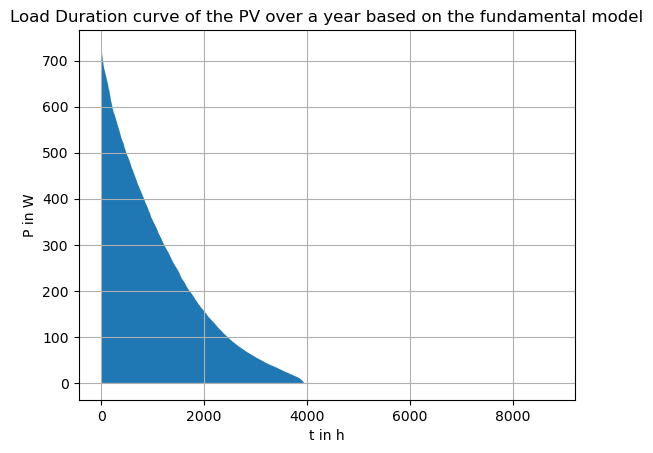

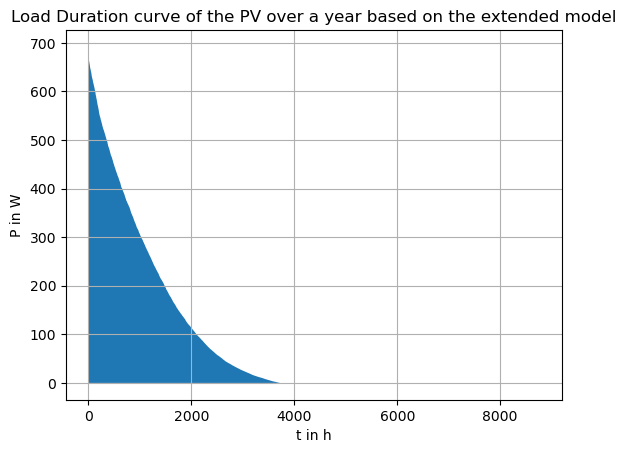

In [ ]:
load_duration_curve(E_gen_fund, 'Load Duration curve of the PV over a year based on the fundamental model')
load_duration_curve(E_gen_ext, 'Load Duration curve of the PV over a year based on the extended model')

We can derive that the extended model yield is steeper and since it takes the temperature variable into account more accurate.

__b. Plotting the monthly yields__

In [ ]:
def monthly_yield_plot(energy_array, title):
    # Creation of daily array
    E_days = np.empty(shape=(365, 1))
    for index, day in enumerate(E_days):
        E_days[index] = sum(energy_array[index*4*24:(index+1)*4*24])
    # Creation of monthly array
    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    E_months = np.empty(shape=(12, 1))
    counter = 0
    for index, month in enumerate(month_days):
        E_months[index] = sum(E_days[counter:counter + month])
        counter += month
    fig, ax = plt.subplots()
    ax.bar(np.arange(1, 13), E_months.flatten() / 1000, zorder=2)
    ax.set_title(title)
    ax.set_xlabel('t in Months')
    ax.set_ylabel('Yield in kWh')
    ax.grid(True, zorder=1)
    plt.show()

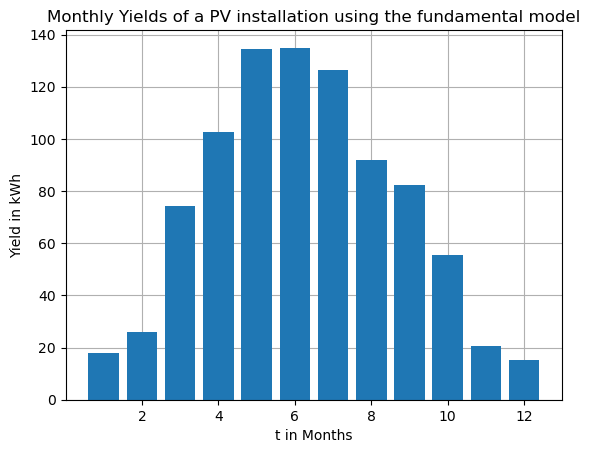

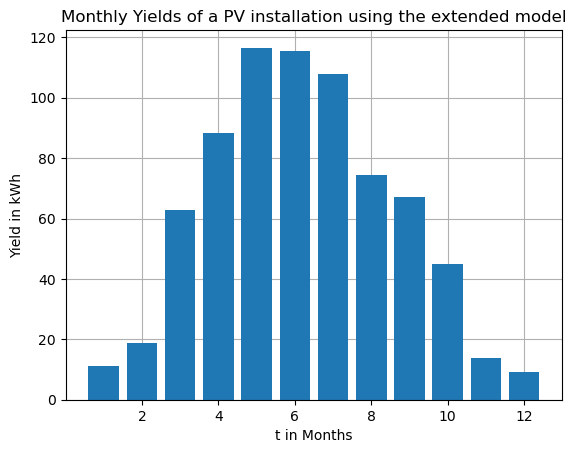

In [ ]:
monthly_yield_plot(E_gen_fund, "Monthly Yields of a PV installation using the fundamental model")
monthly_yield_plot(E_gen_ext, "Monthly Yields of a PV installation using the extended model")

__c. The maximum and minimum yield days__

In [ ]:
def maximum_minimum_yield_days(energy_array,header):
    start_date = datetime(2005, 1, 1, 0, 0, 0)
    E_days = np.empty(shape=(365, 1))
    E_days_energy = np.empty(shape=(365, 1))
    for index, day in enumerate(E_days):
        E_days[index] = sum(energy_array[index*4*24:(index+1)*4*24])
    energy_array_dict = {E_days.flatten()[i]: i for i in range(len(E_days))}
    E_days = np.sort(E_days, axis=None)[::-1]
    max_dates = E_days[0:5]
    day_timedelta = timedelta(days=1)
    print(header)
    for date in max_dates.flatten():
        print(f"Maximum on {(start_date + energy_array_dict[date]*day_timedelta).date()} equals to {round(int(date)/1000,5)} kWh")
    min_dates = E_days[-5:]
    print("")
    for date in min_dates.flatten():
        print(f"Minimum on {(start_date + energy_array_dict[date]*day_timedelta).date()} equals to {round(int(date)/1000,5)} kWh")
    print("\n")

In [ ]:
maximum_minimum_yield_days(E_gen_fund, "Maximum and Minimum yield days of 2005 for the fundamental model:")
maximum_minimum_yield_days(E_gen_ext,  "Maximum and Minimum yield days of 2005 for the extended model:")

Maximum and Minimum yield days of 2005 for the fundamental model:
Maximum on 2005-06-21 equals to 6.078 kWh
Maximum on 2005-06-24 equals to 6.068 kWh
Maximum on 2005-06-23 equals to 6.033 kWh
Maximum on 2005-06-03 equals to 6.031 kWh
Maximum on 2005-07-04 equals to 5.987 kWh

Minimum on 2005-12-28 equals to 0.242 kWh
Minimum on 2005-12-03 equals to 0.24 kWh
Minimum on 2005-11-27 equals to 0.233 kWh
Minimum on 2005-12-31 equals to 0.219 kWh
Minimum on 2005-12-06 equals to 0.212 kWh


Maximum and Minimum yield days of 2005 for the extended model:
Maximum on 2005-05-28 equals to 5.506 kWh
Maximum on 2005-06-24 equals to 5.398 kWh
Maximum on 2005-05-29 equals to 5.353 kWh
Maximum on 2005-07-04 equals to 5.334 kWh
Maximum on 2005-06-21 equals to 5.319 kWh

Minimum on 2005-11-22 equals to 0.086 kWh
Minimum on 2005-12-03 equals to 0.081 kWh
Minimum on 2005-11-27 equals to 0.074 kWh
Minimum on 2005-12-06 equals to 0.066 kWh
Minimum on 2005-12-31 equals to 0.061 kWh




As expected the highest yield days are during the summer days, and the lowest during the winter,and as usual,
the fundamental model values are higher than the more accurate extended model.

__d. Diagram of partial radiations__

In [ ]:
def plot_partial_radiations(longitude,latitude,alpha_pv, gamma_pv,albedo_factor):
    alpha_s, gamma_s = sonnenstand(longitude, latitude, time_df)
    theta_gen = incidence_angle(gamma_s, alpha_s, np.radians(alpha_pv),
                                np.radians(gamma_pv))
    E_dir_gen = direct_radiation(theta_gen, gamma_s)
    E_refl_gen = reflected_radiation(albedo_factor, np.radians(gamma_pv))
    E_diff_gen = diffuse_radiation(np.radians(gamma_pv))

    E_dir_gen_day = np.empty(shape=(365, 1))
    E_refl_gen_day = np.empty(shape=(365, 1))
    E_diff_gen_day = np.empty(shape=(365, 1))
    for index, day in enumerate(E_dir_gen_day):
        E_dir_gen_day[index] = sum(E_dir_gen[index*4*24:(index+1)*4*24])
        E_refl_gen_day[index] = sum(E_refl_gen[index*4*24:(index+1)*4*24])
        E_diff_gen_day[index] = sum(E_diff_gen[index*4*24:(index+1)*4*24])
    # combine into array
    partial_radiations = np.array([E_dir_gen_day.flatten(), E_refl_gen_day.flatten(), E_diff_gen_day.flatten()])

    # plot as area chart
    plt.figure('Strahlungsanteile')
    plt.stackplot(range(1, 366), partial_radiations,
                  labels=['Direct Radiation', 'Diffuse Radiation',
                          'Reflected Radiation'])
    plt.title('Radiation yields per radiation type')
    plt.xlabel('Day')
    plt.ylabel('Yield in Wh/m²')
    plt.legend()
    plt.show()

96


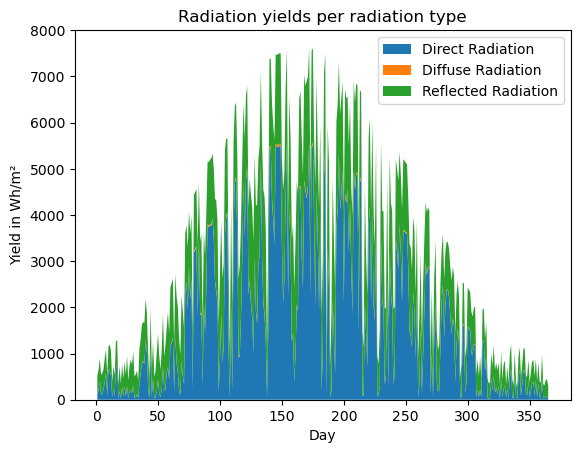

In [ ]:
plot_partial_radiations(VIENNA_LONGITUDE,VIENNA_LATITUDE,PV_AZIMUTH_DEGREES, PV_HEIGHT_ANGLE_DEGREES,ALBEDO_FACTOR)

Here it's suprising to observe how little influence the diffuse radiation has on the whole model, while also deducing that reflected and direct radiations both play a core role in the total energy yield.

__e. December and June day to day energy yield box plots__

In [ ]:
def june_and_dec_boxplots(energy_array, model):

    # Extract the values for each month
    energy_array_june = energy_array[14496:17377]
    energy_array_dec = energy_array[32064:35041]

    # Sum the 15-minute intervals to days
    energy_array_june_hours = np.zeros(720)
    for z in range(0, 720):
        energy_summ = 0
        for i in range(z * 4, (z + 1) * 4):
            energy_summ += energy_array_june[i]
        energy_array_june_hours[z] = energy_summ

    energy_array_dec_hours = np.zeros(744)
    for z in range(0, 744):
        energy_summ = 0
        for i in range(z * 4, (z + 1) * 4):
            energy_summ += energy_array_dec[i]
        energy_array_dec_hours[z] = energy_summ

    june_matrix = np.zeros((24, 30))
    for s in range(0, 30):
        june_matrix[:, s] = energy_array_june_hours[s * 24:(s + 1) * 24]

    dec_matrix = np.zeros((24, 31))
    for s in range(0, 31):
        dec_matrix[:, s] = energy_array_dec_hours[s * 24:(s + 1) * 24]

    fig, ax = plt.subplots()
    ax.boxplot(june_matrix.T)
    ax.set_title(f'Average Energy yield per hour in June for the {model}')
    ax.grid(True)
    ax.set_xlabel('t in Hours')
    ax.set_ylabel('Average Yield in Wh')

    fig, ax = plt.subplots()
    ax.boxplot(dec_matrix.T)
    ax.set_title(f'Average Energy yield per hour in December for the {model}')
    ax.grid(True)
    ax.set_xlabel('t in Hours')
    ax.set_ylabel('Average Yield in Wh')
    plt.show()

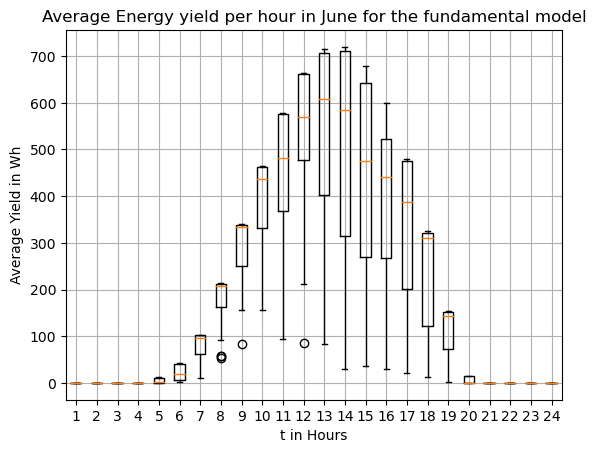

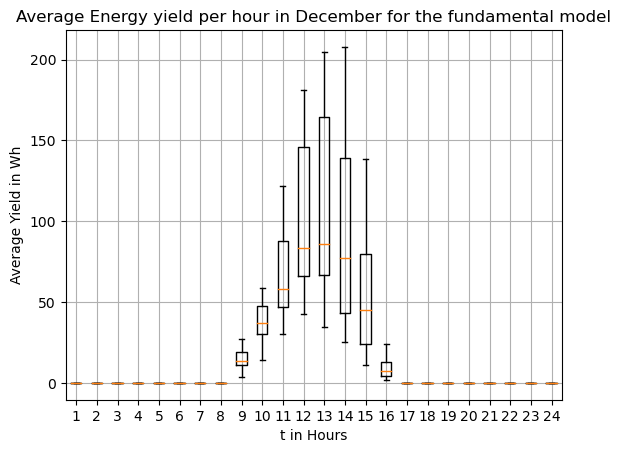

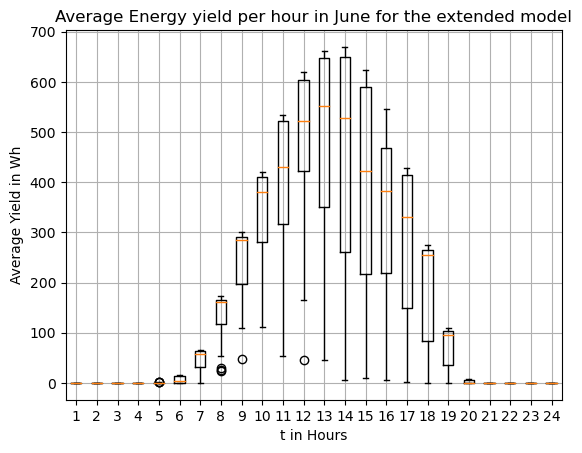

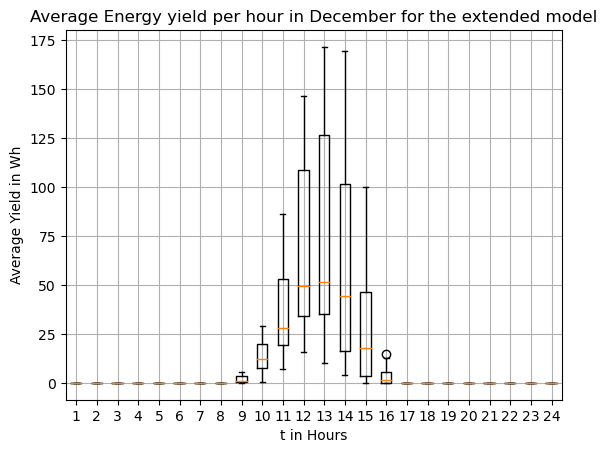

In [ ]:
june_and_dec_boxplots(E_gen_fund, "fundamental model")
june_and_dec_boxplots(E_gen_ext, "extended model")

A basic difference between the extended and fundamental model showcased here is the rather big variation that the average day yield has when taking the temperature into consideration, especially some extreme outliers, like low yields during the midday. In the case of december when bad weather is expected the outliers are closer to the IQR, whereas during June they are much further distributed. This once again proves that the extended model is more accurate.

Note: Unfortunately due to illness and time constraints I was only able to finish up to this part.